# **Tiny Imagenet - Super Resolution**

We will be working on super-resolution and not classification tasks in this NB.

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar
from glob import glob
import warnings; warnings.filterwarnings('ignore')

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Data Processing**

Copying over sections from the previous NBs.

In [4]:
path_data = Path('data')
path = path_data/'tiny-imagenet-200'
bs = 512
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [5]:
path

Path('data/tiny-imagenet-200')

**For tasks like super-resolution (and image reconstruction in general) we must ensure that both the dependant and independant data receive the same amount of data augmentation.** 

In [6]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

- We will add random erasing just for the training set. This makes the task of learning more difficult for the model and forces it to learn to replace missing pixels.
- In `TfmDS` the argument `tfmx` applies transformations / augmentations to the independant variable. In turn `tfmx()` applies `TF.resize()` to the 32x32 image, making it 64x64 and interpolates. This effectively doubles up the pixel count. 

In [13]:
# We will add random erasing just for the training set. This makes the task of learning more
# difficult for the model and forces it to learn to replace missing pixels.
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [9]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [10]:
xb,yb = next(iter(dls.train))

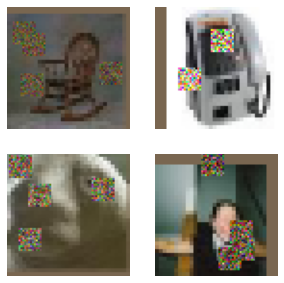

In [11]:
show_images(denorm(xb[:4]), imsize=2.5)

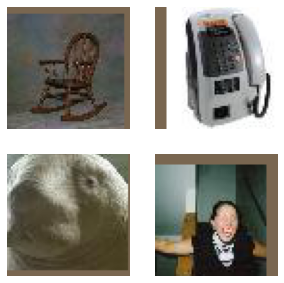

In [12]:
show_images(denorm(yb[:4]), imsize=2.5)

## **Implementing a Denoising AutoEncoder**

The `upblock` basically doubles the pixels through sequential upsampling. This is followed by an extra Resblock at the end to return 3 channels.

So this model basically takes images which are squeezed into smaller representations, and then these representations are brought back up to their super-resolution target. 

In [15]:
def upblock(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [17]:
def get_model(act=act_gr, nfs=(32, 64, 128, 256, 512, 1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) 
               for i in range(len(nfs)-1)]
    layers += [upblock(nfs[i], nfs[i-1], act=act, norm=norm) 
               for i in range(len(nfs)-1, 0, -1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [18]:
iw = partial(init_weights, leaky=0.1)

In [19]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

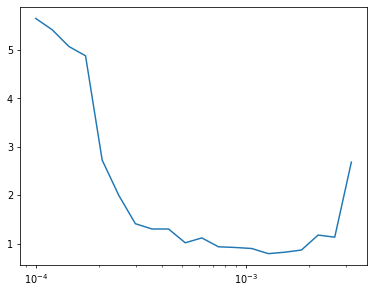

In [20]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, 
        opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [21]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.586,0,train
0.373,0,eval
0.317,1,train
0.278,1,eval
0.254,2,train
0.229,2,eval
0.229,3,train
0.210,3,eval
0.222,4,train
0.208,4,eval


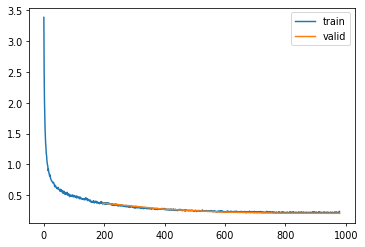

In [22]:
learn.fit(epochs)

loss,epoch,train
0.208,0,eval


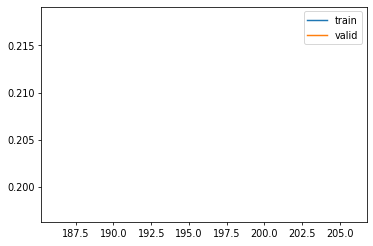

In [23]:
# predictions, targets and inputs extracted from the model
p, t, inp = learn.capture_preds(inps=True)

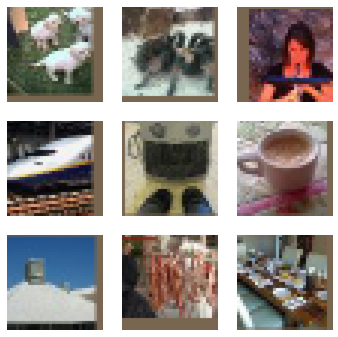

In [24]:
show_images(denorm(inp[:9]), imsize=2)

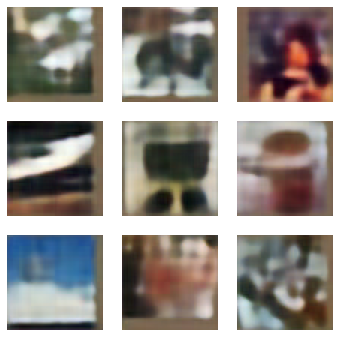

In [25]:
show_images(denorm(p[:9]), imsize=2)

These results are quite bad!!

The fundamental problem lies with the AutoEncoder, especially smaller AutoEncoders to carry out the task of super-resolution.

Instead of adding additional complexity, we can instead simplify the model using the UNet architecture.

## **Switching Over To A UNET**